# Bot identification
1) Identify the most likely bot accounts
2) Get their locations

## Assumptions
1) Any account with more than an average of 100 tweets per day is a bot
    * Therefore I will say that accounts with more than 100*365~=35000 tweets per year is a bot.
    * Take the number of years the user has been on the platform (num_years_on_twitter = 2022-usercreatedts["year"] + 1)
    * If totaltweets > (num_years_on_twitter*35000): Bot = True

# Read all the data into a df

In [16]:
import pandas as pd

pkl_path = "/Users/hannojacobs/MIT805_datasets/Ukraine_full.pkl"

# Load the csv from a pkl file
df = pd.read_pickle(pkl_path)
print(df.head())
print(df.columns)

  Unnamed: 0               userid         username  \
0    3544308            454230077       veronicae9   
1    3544309  1166381062248783874  forcemultstevea   
2    3544310            159230211       tammytabby   
3    3544311  1498015615881302016  ArthurC54762353   
4    3544312   867157331494268929    GideonNeptune   

                                            acctdesc         location  \
0                                                NaN           madrid   
1  AI startup advisor 'force multiplier' who shap...       Olympia WA   
2  Native of New York City, NY. \nConservative.\n...        Georgia     
3                                                NaN              NaN   
4  Heard expert say “30% of a given population at...  Here, right now   

  following  followers totaltweets               usercreatedts  \
0    3546.0     1459.0    119958.0  2012-01-03 19:23:33.000000   
1    1020.0      731.0    101791.0  2019-08-27 16:05:01.000000   
2   15602.0    15597.0    411214.0  20

## Do some preprocessing

### Remove unwanted columns

In [17]:
columns_to_keep = [ 
                    "location",
                    "following",
                    "followers",
                    "totaltweets",
                    "usercreatedts",
                    "tweetcreatedts",
                    "retweetcount",
                    "text",
                    "language",
                    "favorite_count",
                    "extractedts",
                    ]
df = df.reindex(columns=columns_to_keep)
print(df.head())
print(f"\n\n columns left =\n{df.columns}")

          location following  followers totaltweets  \
0           madrid    3546.0     1459.0    119958.0   
1       Olympia WA    1020.0      731.0    101791.0   
2        Georgia     15602.0    15597.0    411214.0   
3              NaN       1.0        3.0       394.0   
4  Here, right now   14199.0    12827.0    134139.0   

                usercreatedts       tweetcreatedts retweetcount  \
0  2012-01-03 19:23:33.000000  2022-03-08 00:01:12         35.0   
1  2019-08-27 16:05:01.000000  2022-03-08 00:01:12         32.0   
2  2010-06-24 20:40:35.000000  2022-03-08 00:01:12         79.0   
3  2022-02-27 19:23:16.000000  2022-03-08 00:01:12         30.0   
4  2017-05-23 23:16:33.000000  2022-03-08 00:01:12        127.0   

                                                text language  favorite_count  \
0  Guillaume Briquet herido y hospitalizado en #M...       es             0.0   
1  "Kyiv Ghost" shot down the #Russian Caliber cr...       en             0.0   
2  #China wants to medi

### Remove all non-english tweets

In [18]:
# drop all tweets where the language is not english
print(f"len df all languages = {len(df)}")
df = df[df['language'] == 'en']
print(f"len df only english = {len(df)}")


len df all languages = 14000000
len df only english = 4506126


### Drop all missing elements

In [19]:
# drop all missing elements
df_cleaned = df.dropna()
df = df_cleaned
del df_cleaned
print(f"len(df) = {len(df)}")

len(df) = 2692986


### Write this df to pkl

In [20]:
pkl_file_path = "/Users/hannojacobs/MIT805_datasets/Ukraine_preprocessed_1.pkl"
df.to_pickle(pkl_file_path)
print(f"Done writing to pkl.")
print(f"pkl file: {pkl_file_path}")

Done writing to pkl.
pkl file: /Users/hannojacobs/MIT805_datasets/Ukraine_preprocessed_1.pkl


### Get account ages

In [21]:
from datetime import datetime
import numpy as np

error_in_line_count = 0
account_age = []
for row_index in range(len(df)):
    # if row_index > 1e5:
    #     break
    try:
        usercreatedts_value = df.iloc[row_index, df.columns.get_loc("usercreatedts")]
        account_creation_date = datetime.strptime(usercreatedts_value, "%Y-%m-%d %H:%M:%S.%f")
        current_date = datetime.now()
        time_difference = (current_date - account_creation_date).total_seconds()
        account_age_in_years = round(float(time_difference / (365.25 * 24 * 60 * 60)),2)
        account_age.append(account_age_in_years)
        # print(f"account_age_in_years = {account_age_in_years} \t usercreatedts_value = {usercreatedts_value}")
    except Exception as e:
        error_in_line_count += 1
        account_age.append("Error_in_line")

print(f"error_in_line_count = {error_in_line_count}")

# add this to the dataframe
df["account_age"] = account_age

print(df.columns)

error_in_line_count = 0
Index(['location', 'following', 'followers', 'totaltweets', 'usercreatedts',
       'tweetcreatedts', 'retweetcount', 'text', 'language', 'favorite_count',
       'extractedts', 'account_age'],
      dtype='object')


### Drop all "Error_in_line" ages

In [22]:
print(f"len(df) before drop = {len(df)}")
df = df[df['account_age'] != 'Error_in_line']
df.reset_index(drop=True, inplace=True)
print(f"len(df) after drop = {len(df)}")

pkl_file_path = "/Users/hannojacobs/MIT805_datasets/Ukraine_preprocessed_2.pkl"
df.to_pickle(pkl_file_path)
print(f"Done writing to pkl.")
print(f"pkl file: {pkl_file_path}")

len(df) before drop = 2692986
len(df) after drop = 2692986
Done writing to pkl.
pkl file: /Users/hannojacobs/MIT805_datasets/Ukraine_preprocessed_2.pkl


## Determine likely bot indexes by num_tweets

1) Any account with more than an average of 100 tweets per day is a bot
    * Therefore I will say that accounts with more than 100*365~=35000 tweets per year is a bot.
    * Take the number of years the user has been on the platform (num_years_on_twitter = 2022-usercreatedts["year"] + 1)
    * If totaltweets > (num_years_on_twitter*35000): Bot = True

In [23]:
error_in_line_count = 0
likely_bot_by_num_messages = []
for row_index in range(len(df)):
    # if row_index > 1e2:
    #     break
    try:
        account_age_value = df.iloc[row_index, df.columns.get_loc("account_age")]
        total_num_tweets = df.iloc[row_index, df.columns.get_loc("totaltweets")]

        allowed_tweets_per_year = 50 * 365
        max_allowed_tweets = int(account_age_value * allowed_tweets_per_year)

        likely_bot = False
        if total_num_tweets > max_allowed_tweets:
            likely_bot = True
        
        likely_bot_by_num_messages.append(likely_bot)
        # print(f"account_age_value = {account_age_value} \t total_num_tweets = {total_num_tweets} \t likely_bot = {likely_bot}")
    except Exception as e:
        error_in_line_count += 1
        likely_bot_by_num_messages.append("Error_in_line")


print(f"error_in_line_count = {error_in_line_count}")

# add this to the dataframe
df["likely_bot_by_num_messages"] = likely_bot_by_num_messages

print(df.columns)

pkl_file_path = "/Users/hannojacobs/MIT805_datasets/Ukraine_preprocessed_3.pkl"
df.to_pickle(pkl_file_path)
print(f"Done writing to pkl.")
print(f"pkl file: {pkl_file_path}")

error_in_line_count = 1387391
Index(['location', 'following', 'followers', 'totaltweets', 'usercreatedts',
       'tweetcreatedts', 'retweetcount', 'text', 'language', 'favorite_count',
       'extractedts', 'account_age', 'likely_bot_by_num_messages'],
      dtype='object')
Done writing to pkl.
pkl file: /Users/hannojacobs/MIT805_datasets/Ukraine_preprocessed_3.pkl


In [24]:
print(f"len(df) before drop = {len(df)}")

df = df[df['likely_bot_by_num_messages'] != 'Error_in_line']
df.reset_index(drop=True, inplace=True)
print(f"len(df) after drop = {len(df)}")

pkl_file_path = "/Users/hannojacobs/MIT805_datasets/Ukraine_preprocessed_4.pkl"
df.to_pickle(pkl_file_path)
print(f"Done writing to pkl.")
print(f"pkl file: {pkl_file_path}")

len(df) before drop = 2692986
len(df) after drop = 1305595
Done writing to pkl.
pkl file: /Users/hannojacobs/MIT805_datasets/Ukraine_preprocessed_4.pkl


### Count the likely number of bots

In [25]:
likely_count_bot_messages_by_num_messages = df['likely_bot_by_num_messages'].sum()
print(f"likely_count_bot_messages_by_num_messages = {likely_count_bot_messages_by_num_messages}")
percentage_messages_likely_bot_by_num_messages = round(likely_count_bot_messages_by_num_messages/len(df)*100,2)
print(f"percentage_messages_likely_bots_by_num_messages = {percentage_messages_likely_bot_by_num_messages}%")

likely_count_bot_messages_by_num_messages = 131737
percentage_messages_likely_bots_by_num_messages = 10.09%


### Where do most bot messages come from?

In [26]:
likely_bot_df = df[df['likely_bot_by_num_messages'] == True]
likely_bot_df.reset_index(drop=True, inplace=True)

list_of_locations = likely_bot_df["location"].tolist()

# print some locations
a = 55
for i in range(a, a+30):
    print(list_of_locations[i])


California, USA
Dallas,TX
背景「アベ・スガ政権の失政により破壊された日本」（心象風景）
KittyVille 🇬🇧
United States
AlfinalDelTunelHayluz
Washington, DC
So Cali
California, USA
E. Coast via W. Coast via WI
Johannesburg, South Africa
Seoul, Republic of Korea
So Cali
Seoul, Republic of Korea
La La Land Evidently
Syria
Not in Gina 
Denver Colorado
Texas, USA
Dayton  #Texas, 77535
California
California
KittyVille 🇬🇧
Middle-California
Rouen
SC
World Wide
Benito Juárez
Earthball (Right now: Germany)
Seb gorkas brain


### Remove all not a-z characters from "list_of_locations"

In [27]:
import re

def remove_non_alphabetic(input_string):
    return re.sub(r'[^a-zA-Z]', '', input_string)

print(f"len(list_of_locations) = {len(list_of_locations)}")
cleaned_locations = [remove_non_alphabetic(location) for location in list_of_locations]
list_of_locations = cleaned_locations
print(f"len(list_of_locations) = {len(list_of_locations)}")

# make all lowercase
for i in list_of_locations:
    i = i.lower()

for i in range(0,50):
    print(list_of_locations[i])

len(list_of_locations) = 131737
len(list_of_locations) = 131737
OlympiaWA
Georgia
Hererightnow
HoustonandNYC
Syria
Ayr
KildonanStPaulWinnipegMB
WESTERNNEWYORK
ColumbusnativeSEOhionow
Syria
FatBitch
ArdenArcadeCA
TheMaritimes
FatBitch
DaytonTexas
HyderabadIndia
Northofnowhere
SantiagodeCompostela
VenezuelaCaracasCaricuao
Syria
KailuaHI

DaytonTexas
algunlugardelplaneta
StateofConfusion
Syria
LosAngelesCA
PEOPLESREPUBLICofNATOSTAN
LaLaLandEvidently
SiliconValleyCA
TennesseeUSA
WoodburyMN
MorningtonPeninsulaMelbourne
london
MissouriUSA
MaracayVenezuela
HonoluluOahuHawaii
CanadaBritishColumbiaPortCoquitlam
stanbulTrkiye
KailuaHI
Syria
Phillyburbs

EverettWA
stanbulTrkiye
FloridaUSA
ColumbiaShuswapC
CaliforniabywayofBelize
MesquiteTexas
NSWAustralia


## Write the Locations to a txt file which can be mapreduced

In [28]:
output_file_path = "/Users/hannojacobs/MIT805_datasets/mapreduced_tweet_fields/post_processed_tweet_fields/bot_unreduced_locations.txt"

# Open the file in write mode and write each location on a new line
with open(output_file_path, 'w') as file:
    for location in list_of_locations:
        file.write(location.lower() + '\n')

print(f"Locations written to {output_file_path}")

Locations written to /Users/hannojacobs/MIT805_datasets/mapreduced_tweet_fields/post_processed_tweet_fields/bot_unreduced_locations.txt


## Now mapreduce that file and get the most common locations

In [29]:
reduced_locations = file_path = "/Users/hannojacobs/MIT805_datasets/mapreduced_tweet_fields/post_processed_tweet_fields/bot_reduced_locations.txt"


word_frequencies_list = []
with open(file_path, 'r') as file:
    for line in file:
        parts = re.split(r'\s+', line.strip())
        
        if len(parts) >= 2:
            word = parts[:]
            frequency = int(parts[-1])
            word_frequencies_list.append([word, frequency])

data = word_frequencies_list
sorted_word_frequencies_list = sorted(data, key=lambda x: x[1], reverse=True)

for item in sorted_word_frequencies_list[0:100]:
    print(item)


[['india', '3350'], 3350]
[['unitedstates', '2972'], 2972]
[['usa', '1759'], 1759]
[['californiausa', '1181'], 1181]
[['floridausa', '1083'], 1083]
[['australia', '1017'], 1017]
[['canada', '937'], 937]
[['uk', '932'], 932]
[['london', '812'], 812]
[['yes', '807'], 807]
[['japan', '771'], 771]
[['londonengland', '769'], 769]
[['planetearth', '705'], 705]
[['texasusa', '685'], 685]
[['tokyo', '659'], 659]
[['losangelesca', '600'], 600]
[['earth', '589'], 589]
[['newdelhiindia', '587'], 587]
[['englandunitedkingdom', '570'], 570]
[['newyorkusa', '548'], 548]
[['riga', '519'], 519]
[['unitedkingdom', '518'], 518]
[['internet', '510'], 510]
[['appisnowavailable', '486'], 486]
[['losangeles', '484'], 484]
[['washingtondc', '440'], 440]
[['berlingermany', '428'], 428]
[['poland', '428'], 428]
[['portlandoregon', '425'], 425]
[['olympiawa', '416'], 416]
[['kualalumpurmalaysia', '409'], 409]
[['ohiousa', '404'], 404]
[['wisconsinusa', '404'], 404]
[['londonuk', '399'], 399]
[['worldwide', '383

## Display the most common locations

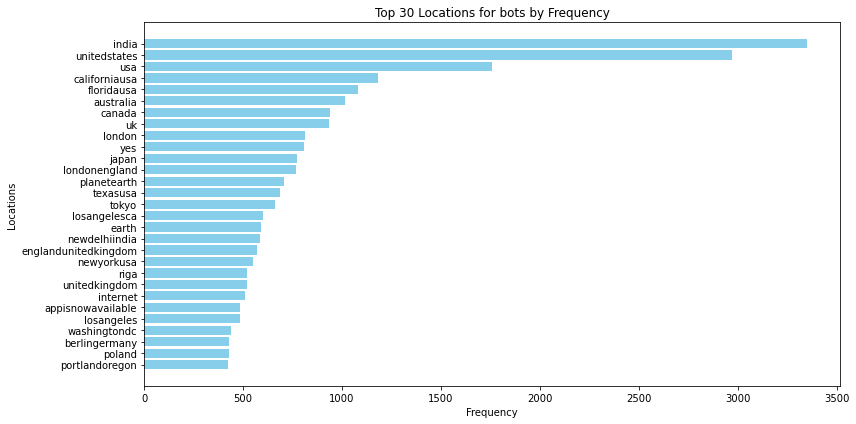

In [30]:
import matplotlib.pyplot as plt

num_words_to_take = 30
top_X_words_and_freq = sorted_word_frequencies_list[0:num_words_to_take-1]
new_i = []
for index, value in enumerate(top_X_words_and_freq):
    name = value[0][0]
    freq = value[1]
    new_i.append([name, freq])

top_X_words_and_freq = new_i
top_X_words, top_X_freq = zip(*top_X_words_and_freq)

plt.figure(figsize=(12, 6))  # Adjust the figure size as needed
plt.barh(top_X_words, top_X_freq, color='skyblue')
plt.gca().invert_yaxis()  # Reverse the order to have the most common word at the top
plt.xlabel('Frequency')
plt.ylabel('Locations')
plt.title(f'Top {num_words_to_take} Locations for bots by Frequency')
plt.tight_layout()
plt.show()

## Consolidate locations into countries

Many of the locations here are cities. Lets consolidate the top 30 locations above into countries.

[['india', 3350], ['unitedstates', 2972], ['usa', 1759], ['californiausa', 1181], ['floridausa', 1083], ['australia', 1017], ['canada', 937], ['uk', 932], ['london', 812], ['yes', 807], ['japan', 771], ['londonengland', 769], ['planetearth', 705], ['texasusa', 685], ['tokyo', 659], ['losangelesca', 600], ['earth', 589], ['newdelhiindia', 587], ['englandunitedkingdom', 570], ['newyorkusa', 548], ['riga', 519], ['unitedkingdom', 518], ['internet', 510], ['appisnowavailable', 486], ['losangeles', 484], ['washingtondc', 440], ['berlingermany', 428], ['poland', 428], ['portlandoregon', 425]]
['india', 'usa', 'canada', 'australia', 'uk', 'japan', 'germany', 'latvia']
[3937, 10605, 937, 1017, 3601, 1430, 428, 519]
[['india', 3937], ['usa', 10605], ['canada', 937], ['australia', 1017], ['uk', 3601], ['japan', 1430], ['germany', 428], ['latvia', 519]]
[['usa', 10605], ['india', 3937], ['uk', 3601], ['japan', 1430], ['australia', 1017], ['canada', 937], ['latvia', 519], ['germany', 428]]


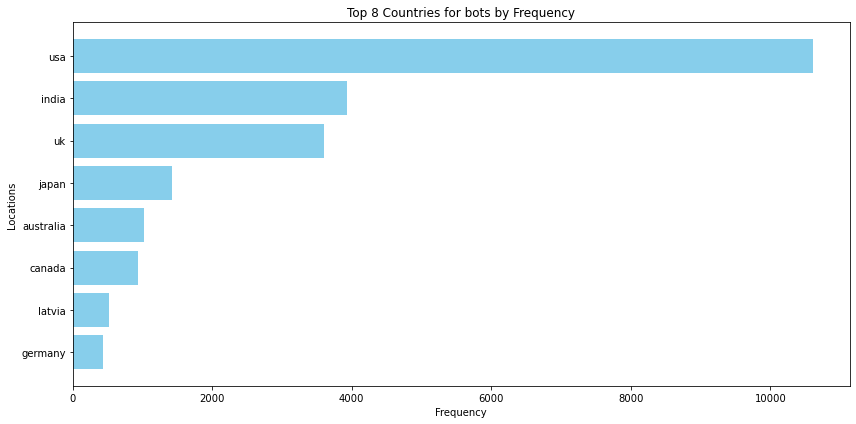

In [31]:
loc_ = top_X_words_and_freq
print(loc_[0:30-1])

india_ = [loc_[0][:],loc_[17][:]]
usa_ = [loc_[1][:],loc_[2][:],loc_[3][:],loc_[4][:],loc_[13][:],loc_[15][:],loc_[19][:],loc_[24][:],loc_[25][:],loc_[27][:],loc_[28][:]]
canada_ = [loc_[6][:]]
australia_ = [loc_[5][:]]
uk_ = [loc_[7][:],loc_[8][:],loc_[11][:],loc_[18][:],loc_[21][:]]
japan_ = [loc_[10][:],loc_[14][:]]
germany_ = [loc_[26][:]]
latvia_ = [loc_[20][:]]
# non_locations_ = [loc_[12][:],loc_[16][:],loc_[22][:],loc_[23][:]]

# countries = [india_, usa_, canada_, australia_, uk_, japan_, germany_, latvia_, non_locations_]
countries = [india_, usa_, canada_, australia_, uk_, japan_, germany_, latvia_]
country_total = []
for country in countries:
    total_ = 0
    for city in country:
        total_ += city[1]
    country_total.append(total_)

# country_names = ["india", "usa", "canada", "australia", "uk", "japan", "germany", "latvia", "non_locations"]
country_names = ["india", "usa", "canada", "australia", "uk", "japan", "germany", "latvia"]


print(country_names)
print(country_total)


country_name_freq = [[name, total] for name, total in zip(country_names, country_total)]
print(country_name_freq)

sorted_country_name_freq = sorted(country_name_freq, key=lambda x: x[1], reverse=True)
print(sorted_country_name_freq)


top_X_words, top_X_freq = zip(*sorted_country_name_freq)

plt.figure(figsize=(12, 6))  # Adjust the figure size as needed
plt.barh(top_X_words, top_X_freq, color='skyblue')
plt.gca().invert_yaxis()  # Reverse the order to have the most common word at the top
plt.xlabel('Frequency')
plt.ylabel('Locations')
plt.title(f'Top {len(country_names)} Countries for bots by Frequency')
plt.tight_layout()
plt.show()

# Takeaways

## USA is the most common bot location
* The majority of total bots which are english speaking seem to come from USA, which is the largest english speaking country in the world.
* Therefore this information is somewhat meaningless.

# Repeat the locations for all tweets, not just english

In [32]:
pkl_path = "/Users/hannojacobs/MIT805_datasets/Ukraine_full.pkl"
df = pd.read_pickle(pkl_path)

columns_to_keep = [ 
                    "location",
                    "following",
                    "followers",
                    "totaltweets",
                    "usercreatedts",
                    "tweetcreatedts",
                    "retweetcount",
                    "text",
                    "language",
                    "favorite_count",
                    "extractedts",
                    ]
df = df.reindex(columns=columns_to_keep)

# drop all missing elements
df_cleaned = df.dropna()
df = df_cleaned
del df_cleaned

from datetime import datetime
import numpy as np

error_in_line_count = 0
account_age = []
for row_index in range(len(df)):
    # if row_index > 1e5:
    #     break
    try:
        usercreatedts_value = df.iloc[row_index, df.columns.get_loc("usercreatedts")]
        account_creation_date = datetime.strptime(usercreatedts_value, "%Y-%m-%d %H:%M:%S.%f")
        current_date = datetime.now()
        time_difference = (current_date - account_creation_date).total_seconds()
        account_age_in_years = round(float(time_difference / (365.25 * 24 * 60 * 60)),2)
        account_age.append(account_age_in_years)
        # print(f"account_age_in_years = {account_age_in_years} \t usercreatedts_value = {usercreatedts_value}")
    except Exception as e:
        error_in_line_count += 1
        account_age.append("Error_in_line")

# add this to the dataframe
df["account_age"] = account_age
df = df[df['account_age'] != 'Error_in_line']
df.reset_index(drop=True, inplace=True)

error_in_line_count = 0
likely_bot_by_num_messages = []
for row_index in range(len(df)):
    # if row_index > 1e2:
    #     break
    try:
        account_age_value = df.iloc[row_index, df.columns.get_loc("account_age")]
        total_num_tweets = df.iloc[row_index, df.columns.get_loc("totaltweets")]

        allowed_tweets_per_year = 50 * 365
        max_allowed_tweets = int(account_age_value * allowed_tweets_per_year)

        likely_bot = False
        if total_num_tweets > max_allowed_tweets:
            likely_bot = True
        
        likely_bot_by_num_messages.append(likely_bot)
        # print(f"account_age_value = {account_age_value} \t total_num_tweets = {total_num_tweets} \t likely_bot = {likely_bot}")
    except Exception as e:
        error_in_line_count += 1
        likely_bot_by_num_messages.append("Error_in_line")

# add this to the dataframe
df["likely_bot_by_num_messages"] = likely_bot_by_num_messages

df = df[df['likely_bot_by_num_messages'] != 'Error_in_line']
df.reset_index(drop=True, inplace=True)
likely_count_bot_messages_by_num_messages = df['likely_bot_by_num_messages'].sum()
percentage_messages_likely_bot_by_num_messages = round(likely_count_bot_messages_by_num_messages/len(df)*100,2)
likely_bot_df = df[df['likely_bot_by_num_messages'] == True]
likely_bot_df.reset_index(drop=True, inplace=True)
list_of_locations = likely_bot_df["location"].tolist()

def remove_non_alphabetic(input_string):
    return re.sub(r'[^a-zA-Z]', '', input_string)

cleaned_locations = [remove_non_alphabetic(location) for location in list_of_locations]
list_of_locations = cleaned_locations

# make all lowercase
for i in list_of_locations:
    i = i.lower()

output_file_path = "/Users/hannojacobs/MIT805_datasets/mapreduced_tweet_fields/post_processed_tweet_fields/bot_all_language_unreduced_locations.txt"

# Open the file in write mode and write each location on a new line
with open(output_file_path, 'w') as file:
    for location in list_of_locations:
        file.write(location.lower() + '\n')

print(f"Locations written to {output_file_path}")

pkl_file_path = "/Users/hannojacobs/MIT805_datasets/Ukraine_preprocessed_all_languages_2.pkl"
df.to_pickle(pkl_file_path)
print(f"Done writing to pkl.")
print(f"pkl file: {pkl_file_path}")

Locations written to /Users/hannojacobs/MIT805_datasets/mapreduced_tweet_fields/post_processed_tweet_fields/bot_all_language_unreduced_locations.txt
Done writing to pkl.
pkl file: /Users/hannojacobs/MIT805_datasets/Ukraine_preprocessed_all_languages_2.pkl


## Now mapreduce that file and get the most common locations

In [33]:
#################################### after mapreduced ####################################
#################################### after mapreduced ####################################
#################################### after mapreduced ####################################

reduced_locations = file_path = "/Users/hannojacobs/MIT805_datasets/mapreduced_tweet_fields/post_processed_tweet_fields/bot_all_language_reduced_locations.txt"

word_frequencies_list = []
with open(file_path, 'r') as file:
    for line in file:
        parts = re.split(r'\s+', line.strip())
        
        if len(parts) >= 2:
            word = parts[:]
            frequency = int(parts[-1])
            word_frequencies_list.append([word, frequency])

data = word_frequencies_list
sorted_word_frequencies_list = sorted(data, key=lambda x: x[1], reverse=True)

## Plot the new list of bot locations

In [34]:
print(sorted_word_frequencies_list[0:num_words_to_take-1])

[[['india', '4927'], 4927], [['unitedstates', '3160'], 3160], [['usa', '1876'], 1876], [['italia', '1331'], 1331], [['californiausa', '1307'], 1307], [['floridausa', '1160'], 1160], [['france', '1082'], 1082], [['japan', '1075'], 1075], [['australia', '1065'], 1065], [['uk', '1004'], 1004], [['canada', '971'], 971], [['london', '877'], 877], [['italy', '853'], 853], [['planetearth', '838'], 838], [['tokyo', '837'], 837], [['londonengland', '836'], 836], [['yes', '807'], 807], [['losangelesca', '751'], 751], [['newdelhiindia', '718'], 718], [['texasusa', '711'], 711], [['thailand', '671'], 671], [['earth', '650'], 650], [['poland', '637'], 637], [['venezuela', '635'], 635], [['berlingermany', '628'], 628], [['newyorkusa', '612'], 612], [['englandunitedkingdom', '611'], 611], [['parisfrance', '580'], 580], [['riga', '559'], 559]]


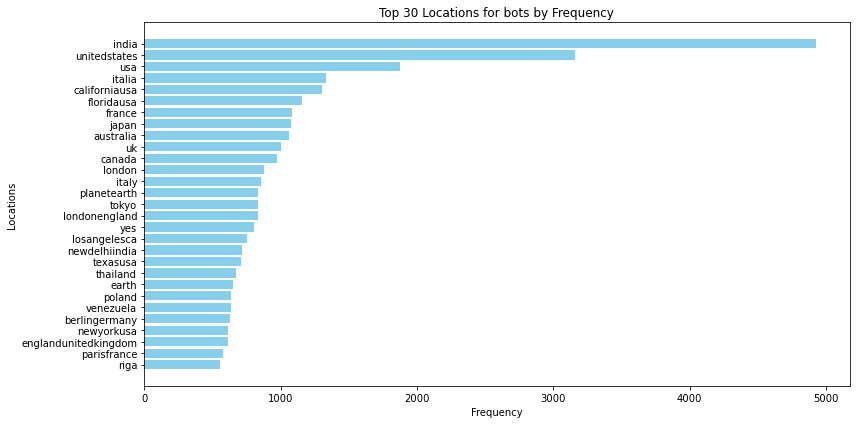

In [35]:
num_words_to_take = 30
top_X_words_and_freq = sorted_word_frequencies_list[0:num_words_to_take-1]
new_i = []
for index, value in enumerate(top_X_words_and_freq):
    name = value[0][0]
    freq = value[1]
    new_i.append([name, freq])

top_X_words_and_freq = new_i
top_X_words, top_X_freq = zip(*top_X_words_and_freq)


plt.figure(figsize=(12, 6))  # Adjust the figure size as needed
plt.barh(top_X_words, top_X_freq, color='skyblue')
plt.gca().invert_yaxis()  # Reverse the order to have the most common word at the top
plt.xlabel('Frequency')
plt.ylabel('Locations')
plt.title(f'Top {num_words_to_take} Locations for bots by Frequency')
plt.tight_layout()
plt.show()

## Consolidate these into the top X most common countries

[['india', 4927], ['unitedstates', 3160], ['usa', 1876], ['italia', 1331], ['californiausa', 1307], ['floridausa', 1160], ['france', 1082], ['japan', 1075], ['australia', 1065], ['uk', 1004], ['canada', 971], ['london', 877], ['italy', 853], ['planetearth', 838], ['tokyo', 837], ['londonengland', 836], ['yes', 807], ['losangelesca', 751], ['newdelhiindia', 718], ['texasusa', 711], ['thailand', 671], ['earth', 650], ['poland', 637], ['venezuela', 635], ['berlingermany', 628], ['newyorkusa', 612], ['englandunitedkingdom', 611], ['parisfrance', 580], ['riga', 559]]
['india_', 'usa_', 'canada_', 'italy_', 'australia_', 'uk_', 'france', 'japan_', 'germany_']
[5645, 9577, 971, 2184, 1065, 3328, 1662, 1912, 428]
[['india_', 5645], ['usa_', 9577], ['canada_', 971], ['italy_', 2184], ['australia_', 1065], ['uk_', 3328], ['france', 1662], ['japan_', 1912], ['germany_', 428]]
[['usa_', 9577], ['india_', 5645], ['uk_', 3328], ['italy_', 2184], ['japan_', 1912], ['france', 1662], ['australia_', 106

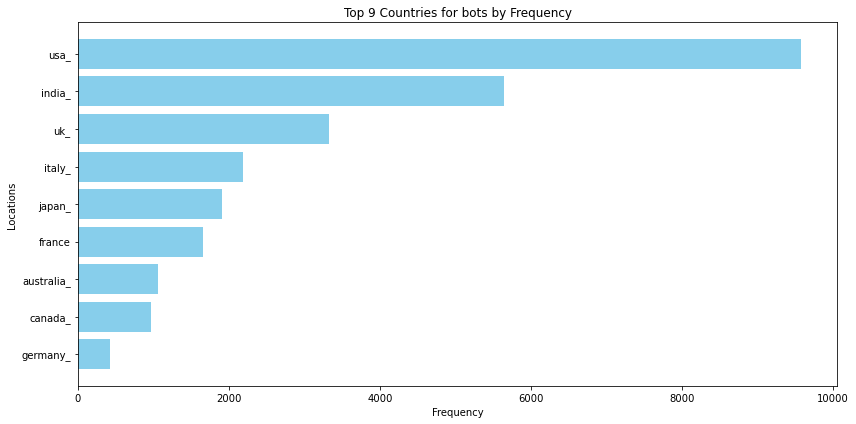

In [38]:
loc_ = top_X_words_and_freq
print(loc_[0:30-1])

india_ = [loc_[0][:],loc_[18][:]]
usa_ = [loc_[1][:],loc_[2][:],loc_[4][:],loc_[5][:],loc_[17][:],loc_[19][:],loc_[25][:]]
canada_ = [loc_[10][:]]
italy_ = [loc_[3][:], loc_[12][:]]
australia_ = [loc_[8][:]]
uk_ = [loc_[9][:],loc_[11][:],loc_[15][:],loc_[26][:]]
france = [loc_[6][:],loc_[27][:],]
japan_ = [loc_[7][:],loc_[14][:]]

countries = [india_, usa_, canada_, italy_, australia_, uk_, france, japan_, germany_]
country_total = []
for country in countries:
    total_ = 0
    for city in country:
        total_ += city[1]
    country_total.append(total_)

country_names = ["india_", "usa_", "canada_", "italy_", "australia_", "uk_", "france", "japan_", "germany_"]


print(country_names)
print(country_total)

country_name_freq = [[name, total] for name, total in zip(country_names, country_total)]
print(country_name_freq)

sorted_country_name_freq = sorted(country_name_freq, key=lambda x: x[1], reverse=True)
print(sorted_country_name_freq)


top_X_words, top_X_freq = zip(*sorted_country_name_freq)

plt.figure(figsize=(12, 6))  # Adjust the figure size as needed
plt.barh(top_X_words, top_X_freq, color='skyblue')
plt.gca().invert_yaxis()  # Reverse the order to have the most common word at the top
plt.xlabel('Frequency')
plt.ylabel('Locations')
plt.title(f'Top {len(country_names)} Countries for bots by Frequency')
plt.tight_layout()
plt.show()

# Takeaways

* USA is stil the most common bot location even when all language tweets are taken into account
* With India in second place
* This could be owing to most tweets being in English and USA is the most populous English speaking country with UK in third.
